<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/BulkAnalyze_chi2blockworsening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def chi2z_arr(arr, blocksize):
  block_zs = np.sum(arr[0:(len(arr)-(len(arr)%blocksize))].reshape(-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdf_block_chi2 = scipy.stats.chi2.cdf(x=np.sum(np.square(block_zs)), df=len(block_zs))
  return cdf_block_chi2

def chi2z_arrs(arrs, blocksize):
  block_zs = np.sum(arrs[:,0:(len(arrs)-(len(arrs)%blocksize))].reshape(
      len(arrs),-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdfs_block_chi2 = scipy.stats.chi2.cdf(
      x=np.sum(np.square(block_zs), axis=-1), df=block_zs.shape[-1])
  return cdfs_block_chi2

def perform_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  blocksizes = [2,3,6,10,15,20]

  for blocksize in blocksizes:
    cdf_block_chi2 = chi2z_arr(values, blocksize)
    cdfs_block_chi2 = chi2z_arrs(rng_permutations, blocksize)

    permutepval_block_chi2 = np.mean(cdfs_block_chi2 >= cdf_block_chi2)
    toreturndict['pval_permute_blocksize'+str(blocksize)] = permutepval_block_chi2
    toreturndict['chi2cdf_permute_blocksize'+str(blocksize)] = cdf_block_chi2

  return toreturndict

In [15]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [17]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
                   "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/chi2blockworsening/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [#("csm1", csm1, csm1_psanalysis),
                                             ("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis = perform_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)

Streaming output truncated to the last 5000 lines.
control4 {'csm1_zscore': -1.2359766823030487, 'length': 86400}
compositez {'pval_permute_blocksize2': 0.917, 'chi2cdf_permute_blocksize2': 0.0652531482897864, 'pval_permute_blocksize3': 0.663, 'chi2cdf_permute_blocksize3': 0.3294891604258798, 'pval_permute_blocksize6': 0.608, 'chi2cdf_permute_blocksize6': 0.37933236120078173, 'pval_permute_blocksize10': 0.292, 'chi2cdf_permute_blocksize10': 0.7040058031584359, 'pval_permute_blocksize15': 0.294, 'chi2cdf_permute_blocksize15': 0.7035657104702496, 'pval_permute_blocksize20': 0.227, 'chi2cdf_permute_blocksize20': 0.7586855618656004} 2.506000280380249
span: control5
control5 {'csm1_zscore': -1.552062926392241, 'length': 86400}
compositez {'pval_permute_blocksize2': 0.847, 'chi2cdf_permute_blocksize2': 0.12523775447740462, 'pval_permute_blocksize3': 0.827, 'chi2cdf_permute_blocksize3': 0.1385012629640574, 'pval_permute_blocksize6': 0.421, 'chi2cdf_permute_blocksize6': 0.5535939260883692, 'pv

In [18]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_chi2blockworsening_controls1to6"

#save the results
open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

1856865

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Mounted at /content/drive
/content/drive/MyDrive/GCP_data


In [19]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_chi2blockworsening_controls1to6"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

#csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [20]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(csm1_psanalysis["test"])),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [32]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(event_metadata_list) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper right", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


compositez
permute_blocksize2
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0001999600079984003
Rankbias p-value: Original Timeperiod pval: 3.5513019701627956e-26
meta-analysis p-value: 1x before pval: 0.5380923815236952
Rankbias p-value: 1x before pval: 0.0750996942187223
meta-analysis p-value: 1x after pval: 0.9978004399120176
Rankbias p-value: 1x after pval: 0.9663833450786732
meta-analysis p-value: 2x before pval: 0.749250149970006
Rankbias p-value: 2x before pval: 0.17513958079776454
meta-analysis p-value: 2x after pval: 0.6762647470505899
Rankbias p-value: 2x after pval: 0.506572333287273
meta-analysis p-value: 3x before pval: 0.973005398920216
Rankbias p-value: 3x before pval: 0.9043981642877286
meta-analysis p-value: 3x after pval: 0.9726054789042191
Rankbias p-value: 3x after pval: 0.2424753786143921


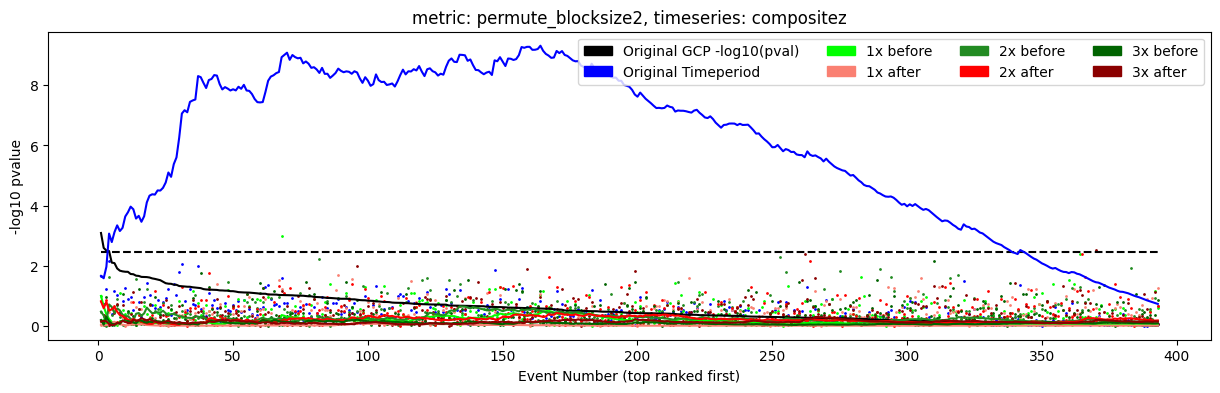

permute_blocksize3
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0003999200159968006
Rankbias p-value: Original Timeperiod pval: 4.883087811151589e-20
meta-analysis p-value: 1x before pval: 0.49190161967606477
Rankbias p-value: 1x before pval: 0.3413893126446989
meta-analysis p-value: 1x after pval: 0.9874025194961008
Rankbias p-value: 1x after pval: 0.8828613596411732
meta-analysis p-value: 2x before pval: 0.7222555488902218
Rankbias p-value: 2x before pval: 0.4098596752980826
meta-analysis p-value: 2x after pval: 0.8860227954409118
Rankbias p-value: 2x after pval: 0.5060246761241117
meta-analysis p-value: 3x before pval: 0.22195560887822435
Rankbias p-value: 3x before pval: 0.9231998588999386
meta-analysis p-value: 3x after pval: 0.9354129174165167
Rankbias p-value: 3x after pval: 0.8227279491672304


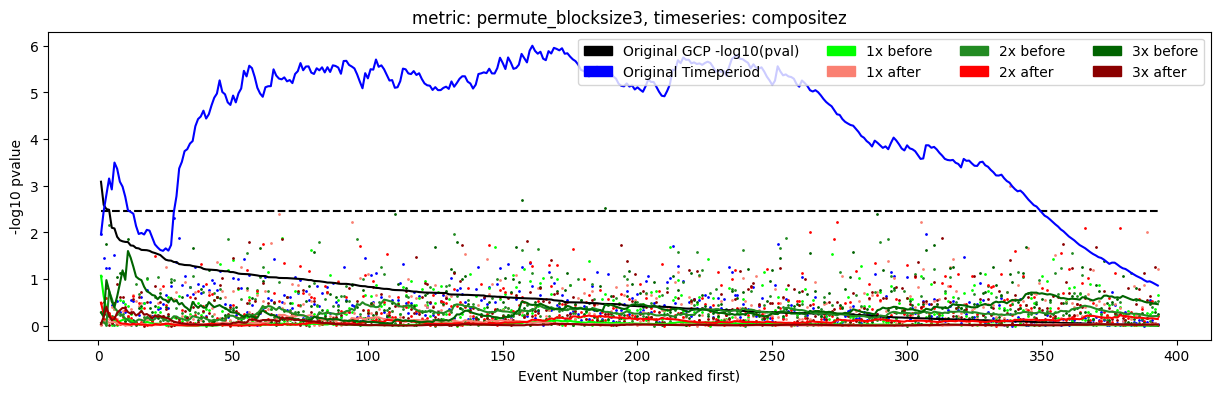

permute_blocksize6
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0001999600079984003
Rankbias p-value: Original Timeperiod pval: 1.1001817842089911e-12
meta-analysis p-value: 1x before pval: 0.1749650069986003
Rankbias p-value: 1x before pval: 0.4717249282948046
meta-analysis p-value: 1x after pval: 0.9808038392321535
Rankbias p-value: 1x after pval: 0.7488588342118667
meta-analysis p-value: 2x before pval: 0.9750049990002
Rankbias p-value: 2x before pval: 0.39833742003706224
meta-analysis p-value: 2x after pval: 0.4455108978204359
Rankbias p-value: 2x after pval: 0.3516913006487259
meta-analysis p-value: 3x before pval: 0.5190961807638472
Rankbias p-value: 3x before pval: 0.9324386402281987
meta-analysis p-value: 3x after pval: 0.9170165966806638
Rankbias p-value: 3x after pval: 0.262497302879961


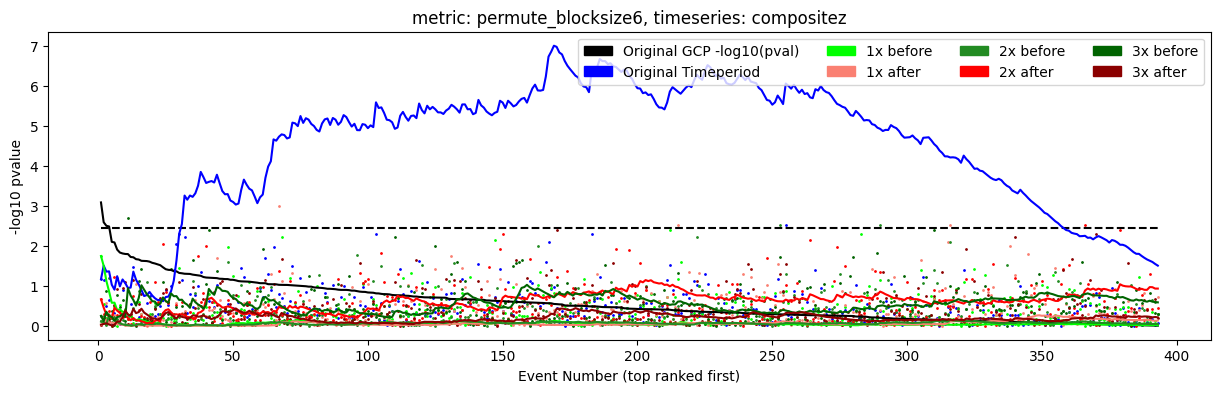

permute_blocksize10
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0597880423915217
Rankbias p-value: Original Timeperiod pval: 2.357122787560746e-05
meta-analysis p-value: 1x before pval: 0.4991001799640072
Rankbias p-value: 1x before pval: 0.5618251641701022
meta-analysis p-value: 1x after pval: 0.9198160367926415
Rankbias p-value: 1x after pval: 0.8687093883389678
meta-analysis p-value: 2x before pval: 0.855628874225155
Rankbias p-value: 2x before pval: 0.19290732469731664
meta-analysis p-value: 2x after pval: 0.19636072785442912
Rankbias p-value: 2x after pval: 0.13453506146831906
meta-analysis p-value: 3x before pval: 0.5056988602279545
Rankbias p-value: 3x before pval: 0.8566504081273167
meta-analysis p-value: 3x after pval: 0.8924215156968607
Rankbias p-value: 3x after pval: 0.3828802619537899


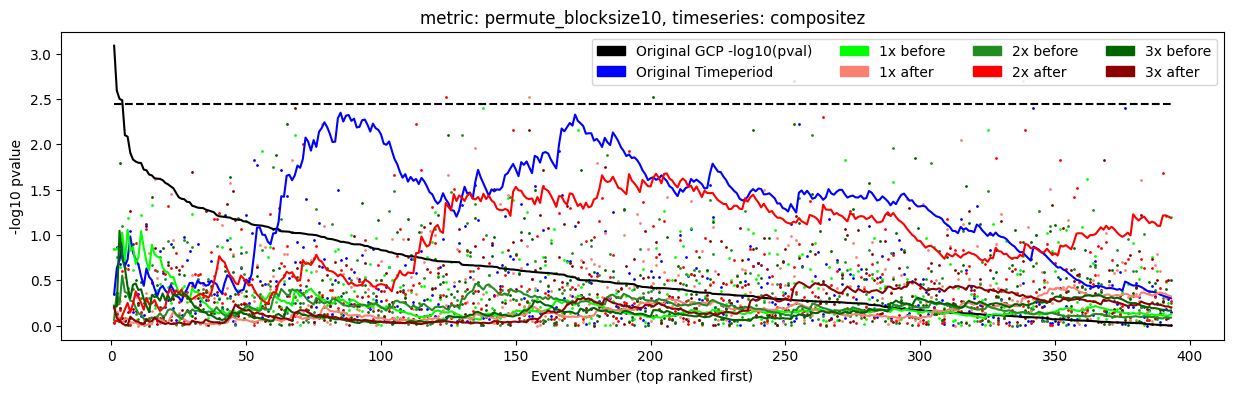

permute_blocksize15
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.41391721655668867
Rankbias p-value: Original Timeperiod pval: 0.0009163421786023
meta-analysis p-value: 1x before pval: 0.041391721655668866
Rankbias p-value: 1x before pval: 0.9061736487938897
meta-analysis p-value: 1x after pval: 0.4839032193561288
Rankbias p-value: 1x after pval: 0.369850776943499
meta-analysis p-value: 2x before pval: 0.7008598280343932
Rankbias p-value: 2x before pval: 0.3511821189347264
meta-analysis p-value: 2x after pval: 0.770245950809838
Rankbias p-value: 2x after pval: 0.2847290160217918
meta-analysis p-value: 3x before pval: 0.7106578684263147
Rankbias p-value: 3x before pval: 0.7945706338925771
meta-analysis p-value: 3x after pval: 0.624875024995001
Rankbias p-value: 3x after pval: 0.4227138635268291


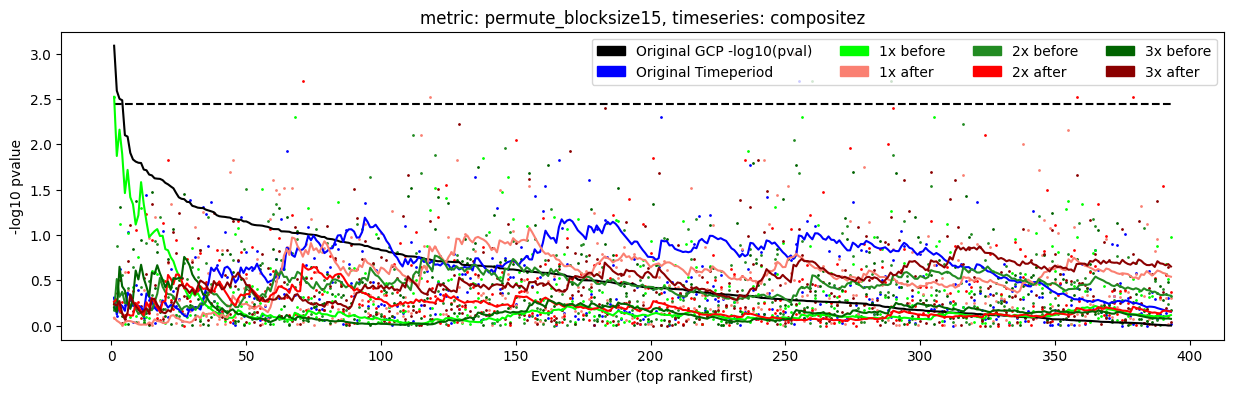

permute_blocksize20
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6944611077784443
Rankbias p-value: Original Timeperiod pval: 0.03835025989308544
meta-analysis p-value: 1x before pval: 0.13377324535092983
Rankbias p-value: 1x before pval: 0.5826528822709238
meta-analysis p-value: 1x after pval: 0.9894021195760848
Rankbias p-value: 1x after pval: 0.8960626175925798
meta-analysis p-value: 2x before pval: 0.982003599280144
Rankbias p-value: 2x before pval: 0.6013093575557088
meta-analysis p-value: 2x after pval: 0.039192161567686463
Rankbias p-value: 2x after pval: 0.05105575470864261
meta-analysis p-value: 3x before pval: 0.4959008198360328
Rankbias p-value: 3x before pval: 0.692339015052541
meta-analysis p-value: 3x after pval: 0.785242951409718
Rankbias p-value: 3x after pval: 0.3402144406311276


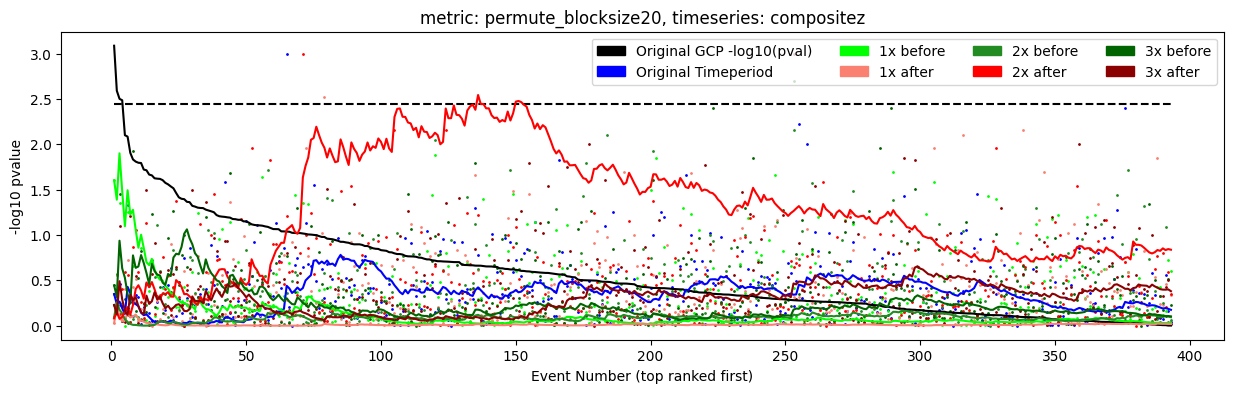

compositez
NEGATIVE permute_blocksize2
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 1.0
Rankbias p-value: Original Timeperiod pval: 1.0
meta-analysis p-value: 1x before pval: 0.4527094581083783
Rankbias p-value: 1x before pval: 0.9250299152363082
meta-analysis p-value: 1x after pval: 0.057388522295540895
Rankbias p-value: 1x after pval: 0.03368513071561512
meta-analysis p-value: 2x before pval: 0.4761047790441912
Rankbias p-value: 2x before pval: 0.8250963753994347
meta-analysis p-value: 2x after pval: 0.6958608278344331
Rankbias p-value: 2x after pval: 0.49379276600701244
meta-analysis p-value: 3x before pval: 0.23035392921415718
Rankbias p-value: 3x before pval: 0.09575734966604971
meta-analysis p-value: 3x after pval: 0.45150969806038793
Rankbias p-value: 3x after pval: 0.7578106586032711


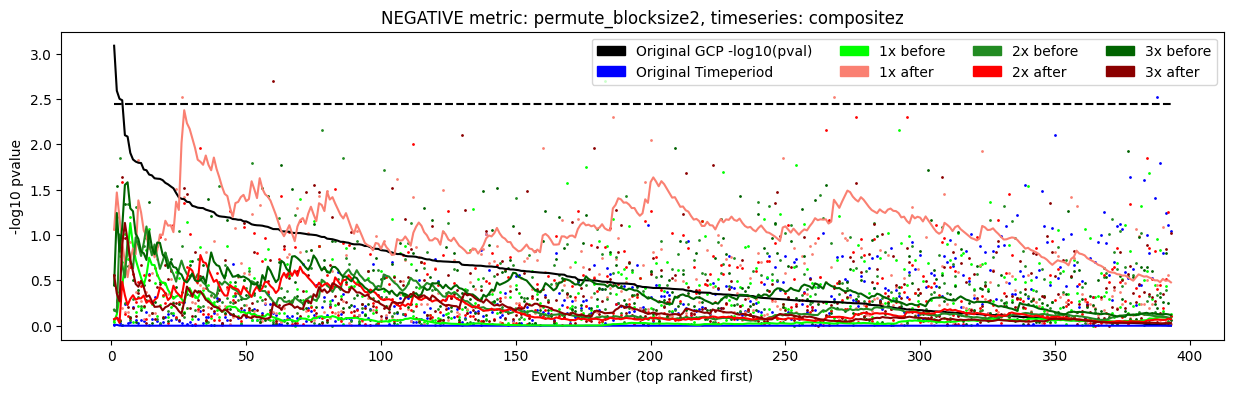

NEGATIVE permute_blocksize3
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 1.0
Rankbias p-value: Original Timeperiod pval: 1.0
meta-analysis p-value: 1x before pval: 0.4195160967806439
Rankbias p-value: 1x before pval: 0.6589465161690908
meta-analysis p-value: 1x after pval: 0.28934213157368527
Rankbias p-value: 1x after pval: 0.11731873630703471
meta-analysis p-value: 2x before pval: 0.16996600679864027
Rankbias p-value: 2x before pval: 0.5904960724579421
meta-analysis p-value: 2x after pval: 0.08198360327934413
Rankbias p-value: 2x after pval: 0.4943404304761399
meta-analysis p-value: 3x before pval: 0.6984603079384123
Rankbias p-value: 3x before pval: 0.07693215223960642
meta-analysis p-value: 3x after pval: 0.4259148170365927
Rankbias p-value: 3x after pval: 0.17751002397237897


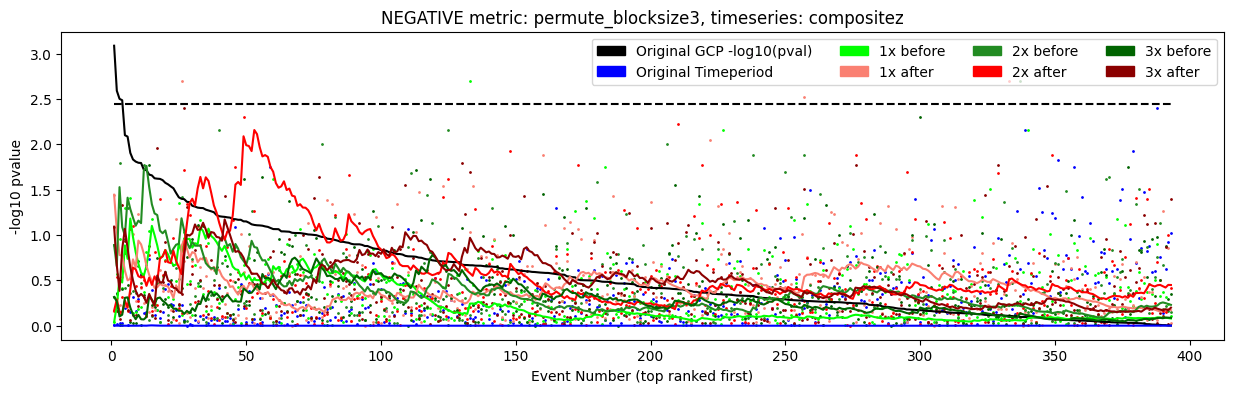

NEGATIVE permute_blocksize6
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9956008798240352
Rankbias p-value: Original Timeperiod pval: 0.999999999998907
meta-analysis p-value: 1x before pval: 0.1903619276144771
Rankbias p-value: 1x before pval: 0.5286392879539129
meta-analysis p-value: 1x after pval: 0.15696860627874426
Rankbias p-value: 1x after pval: 0.2514328136416501
meta-analysis p-value: 2x before pval: 0.20655868826234752
Rankbias p-value: 2x before pval: 0.602015763154484
meta-analysis p-value: 2x after pval: 0.8772245550889822
Rankbias p-value: 2x after pval: 0.6486482535096352
meta-analysis p-value: 3x before pval: 0.28754249150169964
Rankbias p-value: 3x before pval: 0.06768102044813536
meta-analysis p-value: 3x after pval: 0.10657868426314737
Rankbias p-value: 3x after pval: 0.7378009585905436


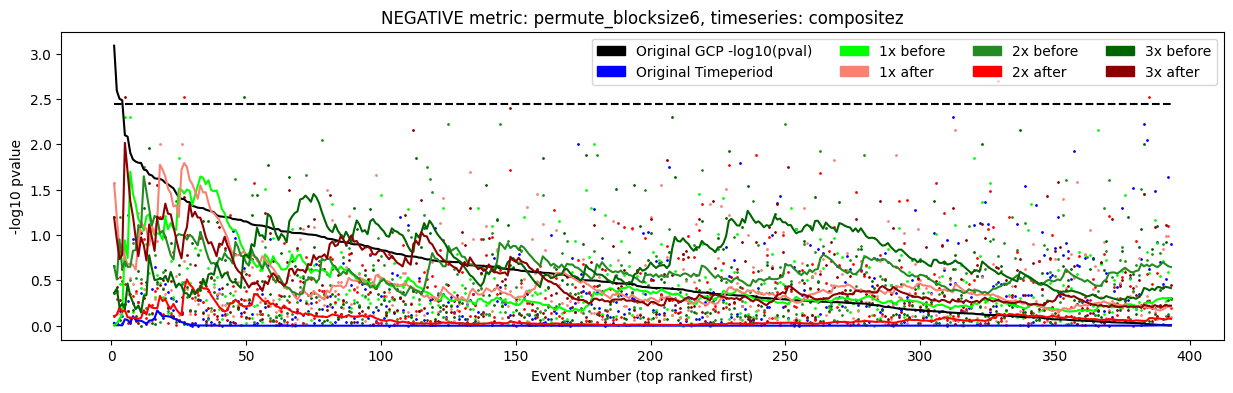

NEGATIVE permute_blocksize10
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9818036392721455
Rankbias p-value: Original Timeperiod pval: 0.9999765211923313
meta-analysis p-value: 1x before pval: 0.8902219556088782
Rankbias p-value: 1x before pval: 0.43853561339173774
meta-analysis p-value: 1x after pval: 0.130373925214957
Rankbias p-value: 1x after pval: 0.13148566305999282
meta-analysis p-value: 2x before pval: 0.6580683863227355
Rankbias p-value: 2x before pval: 0.8073432742411767
meta-analysis p-value: 2x after pval: 0.44931013797240554
Rankbias p-value: 2x after pval: 0.8656630936689169
meta-analysis p-value: 3x before pval: 0.3225354929014197
Rankbias p-value: 3x before pval: 0.14355670285253902
meta-analysis p-value: 3x after pval: 0.37792441511697666
Rankbias p-value: 3x after pval: 0.6174689850639388


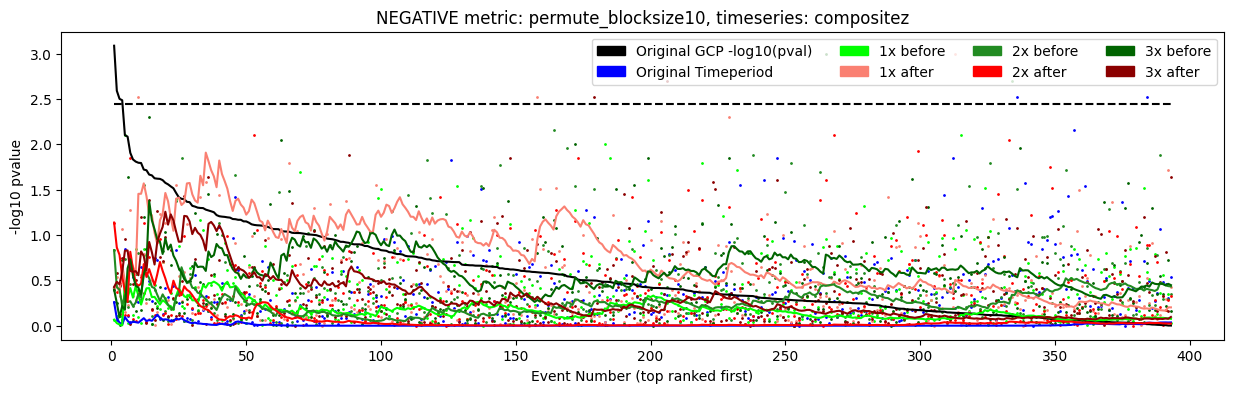

NEGATIVE permute_blocksize15
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9060187962407519
Rankbias p-value: Original Timeperiod pval: 0.9990864980167689
meta-analysis p-value: 1x before pval: 0.7564487102579485
Rankbias p-value: 1x before pval: 0.0939797323617827
meta-analysis p-value: 1x after pval: 0.30553889222155567
Rankbias p-value: 1x after pval: 0.630494708539012
meta-analysis p-value: 2x before pval: 0.891621675664867
Rankbias p-value: 2x before pval: 0.649157257019152
meta-analysis p-value: 2x after pval: 0.9554089182163568
Rankbias p-value: 2x after pval: 0.7155815019662499
meta-analysis p-value: 3x before pval: 0.21695660867826436
Rankbias p-value: 3x before pval: 0.20568984341769242
meta-analysis p-value: 3x after pval: 0.8298340331933614
Rankbias p-value: 3x after pval: 0.5776443764509238


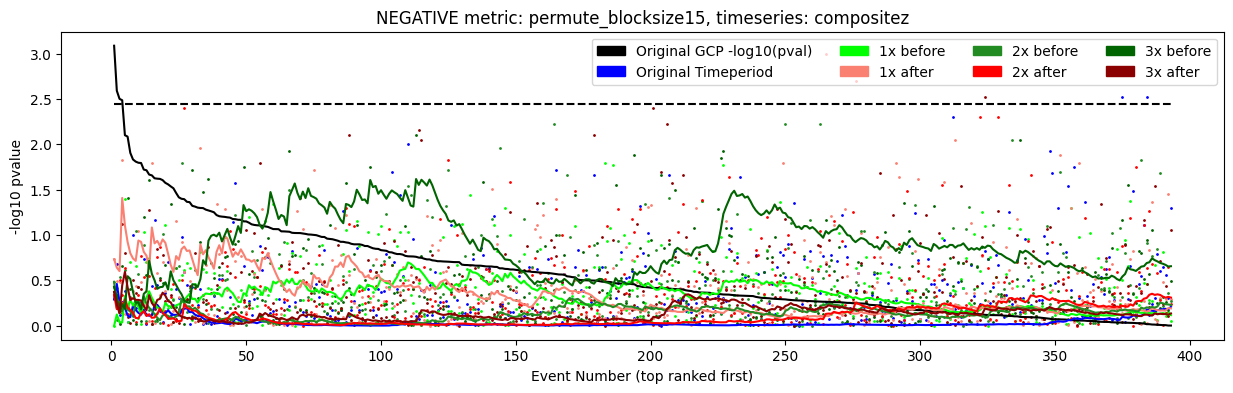

NEGATIVE permute_blocksize20
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.903619276144771
Rankbias p-value: Original Timeperiod pval: 0.961725893767936
meta-analysis p-value: 1x before pval: 0.6442711457708459
Rankbias p-value: 1x before pval: 0.41770443253658746
meta-analysis p-value: 1x after pval: 0.11717656468706258
Rankbias p-value: 1x after pval: 0.10410268690054103
meta-analysis p-value: 2x before pval: 0.45570885822835433
Rankbias p-value: 2x before pval: 0.3990439921054397
meta-analysis p-value: 2x after pval: 0.7150569886022795
Rankbias p-value: 2x after pval: 0.9490401567252049
meta-analysis p-value: 3x before pval: 0.5672865426914617
Rankbias p-value: 3x before pval: 0.3079828967843091
meta-analysis p-value: 3x after pval: 0.4003199360127974
Rankbias p-value: 3x after pval: 0.6601209466365315


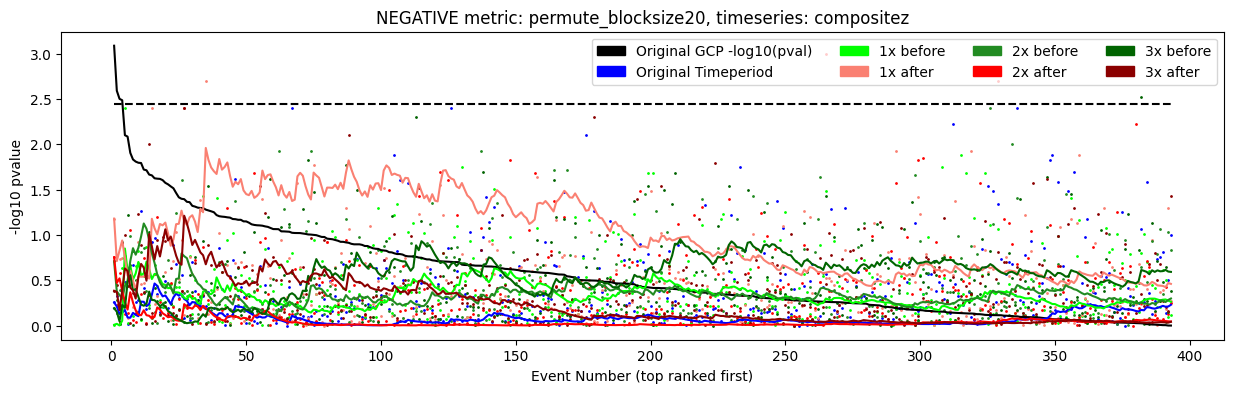

In [33]:
spannames = ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after', '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon', 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

blocksizes = [2,3,6,10,15,20]
for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['permute_blocksize'+str(x) for x in blocksizes]):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['permute_blocksize'+str(x) for x in blocksizes]):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [34]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:Original Timeperiod; signal:compositez; metric:permute_blocksize2',
  0.0001999600079984003,
  0.016796640671865627),
 ('span:Original Timeperiod; signal:compositez; metric:permute_blocksize6',
  0.0001999600079984003,
  0.008398320335932814),
 ('span:Original Timeperiod; signal:compositez; metric:permute_blocksize3',
  0.0003999200159968006,
  0.011197760447910418),
 ('span:2x after; signal:compositez; metric:permute_blocksize20',
  0.039192161567686463,
  0.8230353929214157),
 ('span:1x before; signal:compositez; metric:permute_blocksize15',
  0.041391721655668866,
  0.695380923815237),
 ('span:1x after; signal:compositez; metric:negative-permute_blocksize2',
  0.057388522295540895,
  0.8034393121375726),
 ('span:Original Timeperiod; signal:compositez; metric:permute_blocksize10',
  0.0597880423915217,
  0.7174565086982604),
 ('span:2x after; signal:compositez; metric:negative-permute_blocksize3',
  0.08198360327934413,
  0.8608278344331134),
 ('span:3x after; signal:composit